### Design CNN Architecture

In this notebook we will:
- **Convolutional Layers:**  
  Define the number of layers, filter sizes, and activation functions.
- **Pooling Layers:**  
  Incorporate max pooling or average pooling to reduce spatial dimensions.
- **Fully Connected Layers:**  
  Add dense layers leading to the output layer with softmax activation for classification.
- **Dropout Layers:**  
  Include dropout layers to prevent overfitting.

### Implement Model
- **Framework-Specific Implementation:**  
  Use TensorFlow/Keras' Model API.
- **Modularity:**  
  Design the architecture to be modular for easy adjustments.
- **Save Model**
  Save the model in keras format for use in other notebook


## Loading rebalanced dataset from TFRecord file

Using dataset: balanced_train_20250218_231144.tfrecord


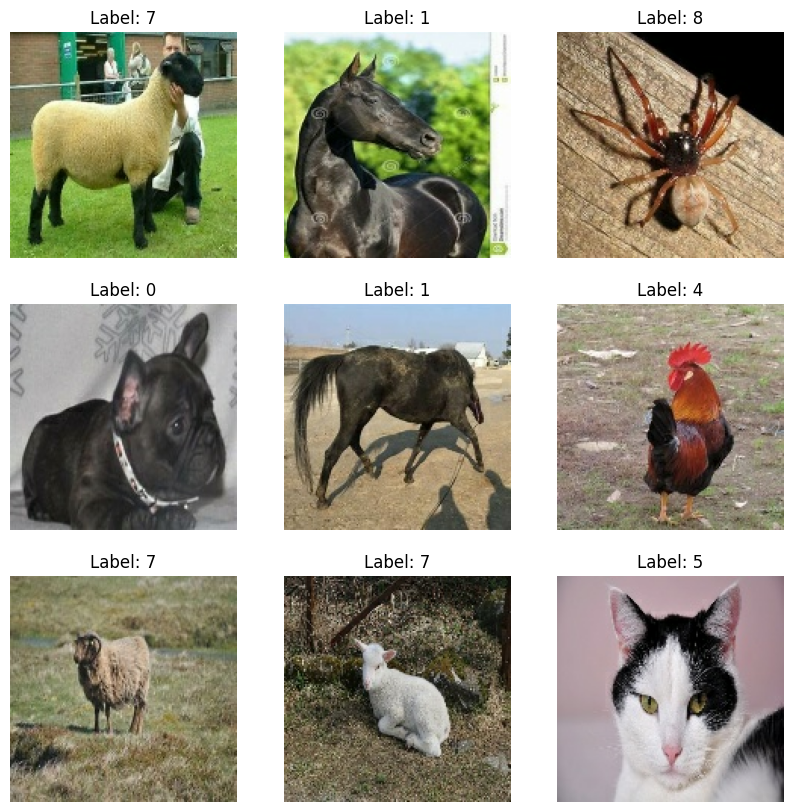

In [1]:
import tensorflow as tf
import glob

# Find the latest TFRecord file
tfrecord_files = sorted(glob.glob("balanced_train_*.tfrecord"))
if not tfrecord_files:
    raise FileNotFoundError("No TFRecord files found. Make sure the dataset was saved correctly.")
latest_tfrecord = tfrecord_files[-1]  # Get the most recent file

print("Using dataset:", latest_tfrecord)

# Define the Parsing Function
# Since images were stored as JPEG and labels as integers, we need a function to decode them properly.

# Define a feature description for parsing TFRecords
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),  # Image stored as a byte string
    'label': tf.io.FixedLenFeature([], tf.int64),   # Label stored as an integer
}

def _parse_function(example_proto):
    """Parse a single example from a TFRecord file."""
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    
    # Decode the JPEG image
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    
    # Normalize image (rescale pixel values to [0, 1])
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize image to match model input size (150x150)
    image = tf.image.resize(image, (150, 150))

    label = tf.cast(parsed['label'], tf.int32)  # Ensure label is int32
    return image, label

 # Create the TFRecord Dataset Pipeline
 # Now that we have a way to parse the dataset, we can load it as a tf.data.Dataset for training.

# Load dataset from TFRecord file
raw_dataset = tf.data.TFRecordDataset(latest_tfrecord)

# Parse dataset
parsed_dataset = raw_dataset.map(_parse_function)

# Batch and optimize dataset
batch_size = 32
train_ds = parsed_dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify dataset loading by displaying a batch
import matplotlib.pyplot as plt

# Take a batch and plot a few images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()
    break



- **Convolutional Layers:**  
  Define the number of layers, filter sizes, and activation functions (e.g., ReLU).
- **Pooling Layers:**  
  Incorporate max pooling or average pooling to reduce spatial dimensions.
- **Fully Connected Layers:**  
  Add dense layers leading to the output layer with softmax activation for classification.
- **Dropout Layers:**  
  Include dropout layers to prevent overfitting.

In [3]:
from tensorflow.keras import layers, models

# Define the CNN model architecture with dropout
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten
    layers.Flatten(),
    
    # Fully connected layers with dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,082 (20.61 MB)

 Trainable params: 5,403,082 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

### Implement Model
- **Framework-Specific Implementation:**  
  Keras  API.
- **Modularity:**  
   This design makes it easy to adjust hyperparameters (like the number of filters, dropout rate, or number of classes)
   and swap out layers if needed.

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import datetime

def create_cnn_model(input_shape=(150, 150, 3), num_classes=10, dropout_rate=0.5):
    # Input layer
    inputs = Input(shape=input_shape, name="input_layer")
    
    # Convolutional Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name="conv1")(inputs)
    x = MaxPooling2D((2, 2), name="maxpool1")(x)
    
    # Convolutional Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name="conv2")(x)
    x = MaxPooling2D((2, 2), name="maxpool2")(x)
    
    # Convolutional Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name="conv3")(x)
    x = MaxPooling2D((2, 2), name="maxpool3")(x)
    
    # Flatten the feature maps
    x = Flatten(name="flatten")(x)
    
    # Fully connected layers with dropout for regularization
    x = Dense(128, activation='relu', name="dense1")(x)
    x = Dropout(dropout_rate, name="dropout1")(x)
    
    # Output layer with softmax activation for classification
    outputs = Dense(num_classes, activation='softmax', name="output")(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name="Modular_CNN_Model")
    return model

# Create and display the model summary
model = create_cnn_model()
model.summary()

# Generate timestamp for filename
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Specify the filename with the timestamp and .keras extension
model_filename = f"my_cnn_model_{timestamp}.keras"

# Save the model in the native Keras format
model.save(model_filename)
print("Model saved in Keras format as:", model_filename)


Model: "Modular_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3 (MaxPooling2D)         │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,082 (20.61 MB)

 Trainable params: 5,403,082 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

Model saved in Keras format as: my_cnn_model_20250218_234853.keras
